In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0,'src/')
import acs5
import nyserda_acs
import prices
import project_sunroof
import nyserda
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc

%matplotlib inline

## Getting the data

In [4]:
raw_data = nyserda_acs.merging_data()
raw_data=raw_data[raw_data['households']>0]

## Generating sample weights

In [5]:
#Duplicate positive rows
duplic = raw_data.loc[raw_data['Project_yes']==1,:]
duplic.loc[:,'Project_yes'] =0
duplic.loc[:,'Duplicate'] = 'Yes'
duplic.loc[:,'weight'] = (duplic.loc[:,'households']-duplic.loc[:,'Project_Number'])
duplic=duplic[duplic['weight']>0]
#Creating weights in old data
raw_data.loc[raw_data['Project_yes'] == 1, 'weight'] = raw_data['Project_Number']
raw_data.loc[raw_data['Project_yes'] == 0, 'weight'] = raw_data['households']
raw_data['Duplicate']='No'
#Merging data 
#Concatenating
all_data = raw_data.append(duplic, ignore_index=True)

/home/ubuntu/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/ubuntu/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [6]:
# Imputing missing values
all_data.loc[all_data['yearly_sunlight_kwh_total'].isnull(), 'yearly_sunlight_kwh_total'] = 0
all_data.loc[all_data['percent_qualified'].isnull(), 'percent_qualified'] = 200
all_data.loc[all_data['Avg_hh_size'].isnull(), 'Avg_hh_size']=np.mean(all_data.Avg_hh_size)
all_data.loc[all_data['median_rooms'].isnull(), 'median_rooms']=5.320409

## Creating AUC Score

In [7]:
# define scoring function 
def custom_auc(ground_truth, predictions):
    # I need only one column of predictions["0" and "1"]. You can get an error here
    # while trying to return both columns at once
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label=1)    
    return auc(fpr, tpr)

# to be standart sklearn's scorer        
my_auc = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

## Large model matrix

In [8]:
all_columns = list(all_data.columns)
acs= acs5.Get_census_data()
acs_data = acs.get_acs_all()
variables_large = acs.education_percent + acs.other_households + acs.units_percent + acs.heating_percent + acs.rooms_percent

In [9]:
variables_large.append('Project_yes')
variables_large.append('Mean_price')
variables_large.append('Var_price')
variables_large.append('percent_qualified')
variables_large.append('yearly_sunlight_kwh_total')
variables_large.append('weight')
variables_large.append('Duplicate')
df_large=all_data[variables_large]

In [10]:
df_large =df_large.dropna()
y_large=df_large['Project_yes']
weights_large=df_large['weight']
X_large=df_large.drop(['Project_yes', 'weight','Duplicate'], axis=1)

In [11]:
X_large.describe()

,Percent_Less_9th,Percent_12th_no_dip,Percent_HighSchool,Percent_Some_college,Percent_Associate,Percent_Bachelors,Percent_Graduate,Percent_more_than_hs,Avg_hh_size,Median_age,...,Percent_5_rooms,Percent_6_rooms,Percent_7_rooms,Percent_8_rooms,Percent_9_more_rooms,median_rooms,Mean_price,Var_price,percent_qualified,yearly_sunlight_kwh_total
count,6015.000000,6015.000000,6015.000000,6015.000000,6015.000000,6015.000000,6015.000000,6015.000000,6015.000000,6015.000000,...,6015.000000,6015.000000,6015.000000,6015.000000,6015.000000,6015.000000,6015.000000,6015.000000,6015.000000,6.015000e+03
mean,0.062039,0.078039,0.280322,0.166529,0.088960,0.183708,0.140403,0.579601,2.692034,39.544472,...,0.172484,0.161023,0.111923,0.082252,0.101888,5.320745,28.991892,209.943795,109.311963,7.147635e+06
std,0.063335,0.054188,0.100124,0.050862,0.040072,0.091024,0.105248,0.160102,0.531530,7.017340,...,0.077076,0.086341,0.077412,0.068406,0.091098,1.205510,4.221908,109.421116,57.705506,1.138075e+07
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.030000,11.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.300000,18.309167,95.470254,21.212121,0.000000e+00
25%,0.019440,0.037396,0.219068,0.133333,0.058932,0.114544,0.064054,0.462948,2.350000,34.700000,...,0.119899,0.094288,0.043603,0.023482,0.033709,4.300000,25.463787,163.361579,70.098957,0.000000e+00
50%,0.038308,0.067114,0.286698,0.167415,0.086894,0.169708,0.111167,0.572153,2.610000,40.300000,...,0.168263,0.166474,0.114379,0.072031,0.085898,5.500000,30.932676,188.915562,81.764706,3.381567e+06
75%,0.083015,0.106013,0.350957,0.198669,0.116232,0.238077,0.187382,0.687781,2.980000,44.400000,...,0.217399,0.217535,0.164569,0.123052,0.144573,6.200000,30.932676,195.928370,200.000000,9.007294e+06
max,0.445956,0.400000,0.793103,0.448276,0.318182,0.764706,0.695565,1.000000,6.270000,82.000000,...,1.000000,1.000000,1.000000,0.809524,1.000000,8.500000,35.571604,477.108098,200.000000,1.720241e+08


## Simple model matrix

In [28]:
variables_simple = ['Percent_Less_9th','Percent_more_than_hs', 'Percent_1_unit','Avg_hh_size',
                'Percent_hh_w_children', 'Percent_10+_units', 'Percent_Heating_electricity',
                'yearly_sunlight_kwh_total'  , 'Percent_6_rooms', 'percent_qualified',
                'Project_yes','weight','Duplicate']

In [29]:
df_simple= all_data[variables_simple]

In [30]:
y_simple=df_simple['Project_yes']
weights_simple=df_simple['weight']
X_simple=df_simple.drop(['Project_yes', 'weight','Duplicate'], axis=1)

## Models using large matrix

In [12]:
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X_large, y_large, weights_large, test_size=0.3, random_state=42)

 Gradient Boosting Classifier w/sample weights

In [13]:
gbc = GradientBoostingClassifier()
gbc_search = GridSearchCV(gbc, param_grid = {'n_estimators' : [1000, 10000], 'subsample' :[0.8],
                                           'max_depth': [2,3], 'learning_rate' : [0.01, 0.001]}, 
                     scoring=my_auc, fit_params={'sample_weight': weights_train}, n_jobs=1, iid=True, refit=True, 
             cv=None, verbose=5, pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)

In [14]:
gbc_fitted = gbc_search.fit(X_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=2 
[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=2, score=0.630297, total=   4.4s
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=2, score=0.645649, total=   4.4s
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.8s remaining:    0.0s


[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=2, score=0.586899, total=   4.4s
[CV] n_estimators=10000, subsample=0.8, learning_rate=0.01, max_depth=2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.2s remaining:    0.0s


[CV]  n_estimators=10000, subsample=0.8, learning_rate=0.01, max_depth=2, score=0.602998, total=  42.8s
[CV] n_estimators=10000, subsample=0.8, learning_rate=0.01, max_depth=2 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   56.2s remaining:    0.0s


[CV]  n_estimators=10000, subsample=0.8, learning_rate=0.01, max_depth=2, score=0.632538, total=  43.1s
[CV] n_estimators=10000, subsample=0.8, learning_rate=0.01, max_depth=2 
[CV]  n_estimators=10000, subsample=0.8, learning_rate=0.01, max_depth=2, score=0.587067, total=  43.5s
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=3, score=0.608747, total=   6.5s
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=3, score=0.632080, total=   6.4s
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=3, score=0.575738, total=   6.4s
[CV] n_estimators=10000, subsample=0.8, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=10000, subsample=0.8, learning_rate=0.01, max_depth=3, score=0.586520, total= 1.1min
[CV] n_estimators

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 12.3min finished


In [25]:
gbc_fitted.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=1000, presort='auto', random_state=None,
              subsample=0.8, verbose=0, warm_start=False)

Logistic Regression w/ sample weights

In [62]:
log = LogisticRegression()
log_fitted = log.fit(X_train,y_train,sample_weight=weights_train)

In [107]:
log_best = LogisticRegression()
log_best_fitted = log.fit(X_large,y_large,sample_weight=weights_large)

Random Forest w/sample weights

In [21]:
rf=RandomForestClassifier()

rf_search = GridSearchCV(rf, param_grid ={'n_estimators':[10, 20, 100], 'max_features':['sqrt', 'log2'], 'max_depth': [2,3,4,5]}, scoring=my_auc, fit_params={'sample_weight': np.array(weights_train)}, n_jobs=1, iid=True, refit=True, 
             cv=None, verbose=5, pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)

In [22]:
rf_fitted = rf_search.fit(X_train,y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] max_features=sqrt, n_estimators=10, max_depth=2 .................
[CV]  max_features=sqrt, n_estimators=10, max_depth=2, score=0.650356, total=   0.1s
[CV] max_features=sqrt, n_estimators=10, max_depth=2 .................
[CV]  max_features=sqrt, n_estimators=10, max_depth=2, score=0.679385, total=   0.1s
[CV] max_features=sqrt, n_estimators=10, max_depth=2 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


[CV]  max_features=sqrt, n_estimators=10, max_depth=2, score=0.607933, total=   0.1s
[CV] max_features=sqrt, n_estimators=20, max_depth=2 .................
[CV]  max_features=sqrt, n_estimators=20, max_depth=2, score=0.683536, total=   0.1s
[CV] max_features=sqrt, n_estimators=20, max_depth=2 .................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


[CV]  max_features=sqrt, n_estimators=20, max_depth=2, score=0.651541, total=   0.1s
[CV] max_features=sqrt, n_estimators=20, max_depth=2 .................
[CV]  max_features=sqrt, n_estimators=20, max_depth=2, score=0.611804, total=   0.1s
[CV] max_features=sqrt, n_estimators=100, max_depth=2 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=2, score=0.650869, total=   0.5s
[CV] max_features=sqrt, n_estimators=100, max_depth=2 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=2, score=0.658947, total=   0.5s
[CV] max_features=sqrt, n_estimators=100, max_depth=2 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=2, score=0.606296, total=   0.5s
[CV] max_features=log2, n_estimators=10, max_depth=2 .................
[CV]  max_features=log2, n_estimators=10, max_depth=2, score=0.675836, total=   0.1s
[CV] max_features=log2, n_estimators=10, max_depth=2 .................
[CV]  max_features=log2, n_estimators=10, max_depth=2, score=

[CV]  max_features=sqrt, n_estimators=20, max_depth=5, score=0.611038, total=   0.2s
[CV] max_features=sqrt, n_estimators=20, max_depth=5 .................
[CV]  max_features=sqrt, n_estimators=20, max_depth=5, score=0.571749, total=   0.2s
[CV] max_features=sqrt, n_estimators=100, max_depth=5 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=5, score=0.590652, total=   0.8s
[CV] max_features=sqrt, n_estimators=100, max_depth=5 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=5, score=0.586541, total=   0.8s
[CV] max_features=sqrt, n_estimators=100, max_depth=5 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=5, score=0.538931, total=   0.8s
[CV] max_features=log2, n_estimators=10, max_depth=5 .................
[CV]  max_features=log2, n_estimators=10, max_depth=5, score=0.626060, total=   0.1s
[CV] max_features=log2, n_estimators=10, max_depth=5 .................
[CV]  max_features=log2, n_estimators=10, max_depth=5, score=

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   23.3s finished


In [97]:
rf_fitted.best_params_

{'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 20}

In [101]:
rf_best=RandomForestClassifier(max_depth=2, max_features= 'sqrt', n_estimators=20)
rf_best_fitted = rf_best.fit(X_large, y_large, sample_weight=np.array(weights_large))

## ROC Curves

In [95]:
gbc_best = GradientBoostingClassifier(n_estimators=1661,max_depth=2, learning_rate=0.001, subsample=0.8)
gbc_best_fitted = model.fit(X_large, y_large, sample_weight=weights_large)

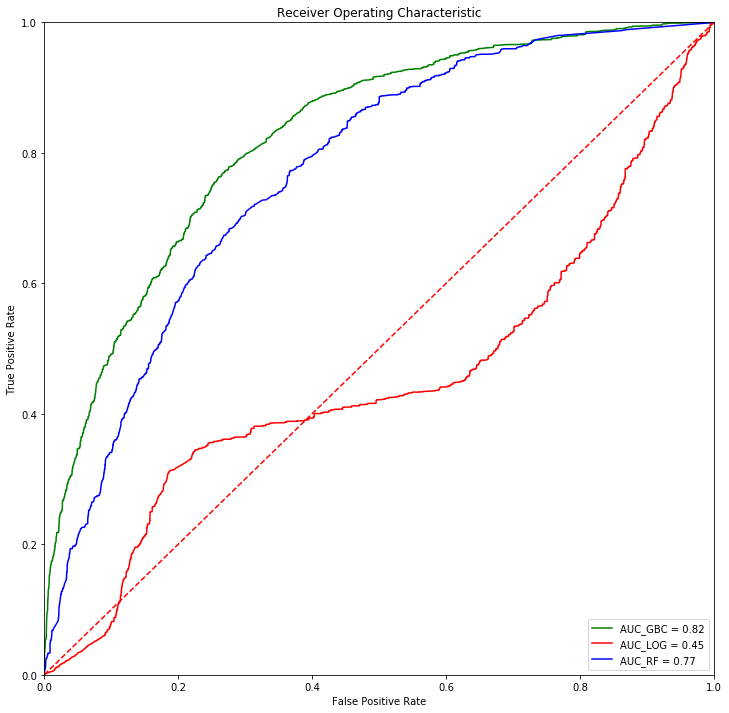

In [113]:
from sklearn import metrics

# calculate the fpr and tpr for all thresholds of the classification
#Gradient Boosting
gbc_probs = gbc_best_fitted.predict_proba(X_large)[:,1]
gbc_fpr, gbc_tpr, gbc_threshold = metrics.roc_curve(y_large, gbc_probs, sample_weight=weights_large)
gbc_roc_auc = metrics.auc(gbc_fpr, gbc_tpr)

#Logistic Regression
log_probs = log_best_fitted.predict_proba(X_large)[:,1]
log_fpr, log_tpr, log_threshold = metrics.roc_curve(y_large, log_probs,sample_weight=weights_large)
log_roc_auc = metrics.auc(log_fpr, log_tpr)

#Random Forest
rf_probs = rf_best_fitted.predict_proba(X_large)[:,1]
rf_fpr, rf_tpr, rf_threshold = metrics.roc_curve(y_large, rf_probs,sample_weight=weights_large)
rf_roc_auc = metrics.auc(rf_fpr, rf_tpr)

# method I: plt
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title('Receiver Operating Characteristic')
ax.plot(gbc_fpr, gbc_tpr, 'b', label = 'AUC_GBC = %0.2f' % gbc_roc_auc, color='green')
ax.plot(log_fpr, log_tpr, 'b', label = 'AUC_LOG = %0.2f' % log_roc_auc, color='red')
ax.plot(rf_fpr, rf_tpr, 'b', label = 'AUC_RF = %0.2f' % rf_roc_auc , color='blue')
ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
fig.savefig('roc_sep8.png')
plt.show()

In [66]:
gbc_fitted.best_params_

{'learning_rate': 0.001,
 'max_depth': 2,
 'n_estimators': 1000,
 'subsample': 0.8}

In [82]:
N_ESTIMATORS=4000

In [83]:
model = GradientBoostingClassifier(n_estimators=N_ESTIMATORS,max_depth=2, learning_rate=0.001, subsample=0.8)
model.fit(X_train, y_train, sample_weight=weights_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=4000, presort='auto', random_state=None,
              subsample=0.8, verbose=0, warm_start=False)

In [84]:
def log_loss(y, y_hat, weights):
    return (1.0 / y.shape[0]) * np.sum(weights*(y*np.log(y_hat) + (1-y)*np.log(1-y_hat)))

In [85]:
train_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(model.staged_predict_proba(X_train)):
    train_score[i] = -log_loss(y_train, y_pred[:, 1], weights_train)

test_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(model.staged_predict_proba(X_test)):
    test_score[i] = -log_loss(y_test, y_pred[:, 1], weights_test)

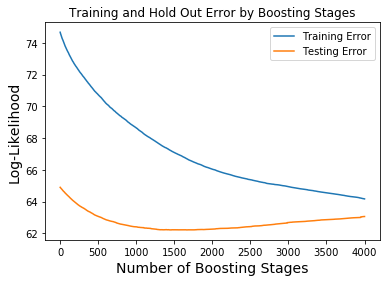

In [86]:
plt.plot(np.arange(N_ESTIMATORS) + 1, train_score,
        label="Training Error")
plt.plot(np.arange(N_ESTIMATORS) + 1, test_score,
        label="Testing Error")
plt.title("Training and Hold Out Error by Boosting Stages")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Log-Likelihood', fontsize=14)
plt.legend(loc="upper right")


plt.savefig('training-and-testing-error.png', bbox_inches='tight')

In [88]:
np.argmin(test_score)

1661

## Model using small matrix

In [31]:
X_train_simple, X_test_simple, y_train_simple, y_test_simple, weights_train_simple, weights_test_simple = train_test_split(X_simple, y_simple, weights_simple, test_size=0.3, random_state=42)

In [51]:
gbc_simple = GradientBoostingClassifier()
gbc_search_simple = GridSearchCV(gbc_simple, param_grid = {'n_estimators' : [500, 1000, 2000], 'subsample' :[0.5,0.8],
                                           'max_depth': [2,3,4,5], 'learning_rate' : [0.1, 0.01, 0.001]}, 
                      scoring=my_auc, fit_params={'sample_weight': weights_train_simple}, n_jobs=1, iid=True, refit=True, 
             cv=None, verbose=5, pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)

In [52]:
gbc_fitted_simple = gbc_search_simple.fit(X_train_simple,y_train_simple)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=2 .
[CV]  n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=2, score=0.602905, total=   1.0s
[CV] n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=2 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=2, score=0.632619, total=   1.0s
[CV] n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=2 .


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV]  n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=2, score=0.588888, total=   1.0s
[CV] n_estimators=500, subsample=0.8, learning_rate=0.1, max_depth=2 .


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s


[CV]  n_estimators=500, subsample=0.8, learning_rate=0.1, max_depth=2, score=0.612964, total=   1.0s
[CV] n_estimators=500, subsample=0.8, learning_rate=0.1, max_depth=2 .


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.9s remaining:    0.0s


[CV]  n_estimators=500, subsample=0.8, learning_rate=0.1, max_depth=2, score=0.534847, total=   1.0s
[CV] n_estimators=500, subsample=0.8, learning_rate=0.1, max_depth=2 .
[CV]  n_estimators=500, subsample=0.8, learning_rate=0.1, max_depth=2, score=0.527130, total=   1.0s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.1, max_depth=2 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.1, max_depth=2, score=0.567987, total=   1.9s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.1, max_depth=2 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.1, max_depth=2, score=0.607172, total=   1.9s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.1, max_depth=2 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.1, max_depth=2, score=0.517174, total=   1.9s
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.1, max_depth=2 
[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.1, max_depth=2, score=0.559583, total=   1.9s
[CV] n_estimators=1000, subsample=0

[CV]  n_estimators=2000, subsample=0.8, learning_rate=0.1, max_depth=4, score=0.543403, total=   6.4s
[CV] n_estimators=2000, subsample=0.8, learning_rate=0.1, max_depth=4 
[CV]  n_estimators=2000, subsample=0.8, learning_rate=0.1, max_depth=4, score=0.566575, total=   6.4s
[CV] n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=5 .
[CV]  n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=5, score=0.497418, total=   2.0s
[CV] n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=5 .
[CV]  n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=5, score=0.577146, total=   1.8s
[CV] n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=5 .
[CV]  n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=5, score=0.560698, total=   2.0s
[CV] n_estimators=500, subsample=0.8, learning_rate=0.1, max_depth=5 .
[CV]  n_estimators=500, subsample=0.8, learning_rate=0.1, max_depth=5, score=0.589068, total=   2.1s
[CV] n_estimators=500, subsample=0.8,

[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=3, score=0.595412, total=   2.7s
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=3, score=0.602322, total=   2.7s
[CV] n_estimators=2000, subsample=0.5, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=2000, subsample=0.5, learning_rate=0.01, max_depth=3, score=0.595298, total=   4.9s
[CV] n_estimators=2000, subsample=0.5, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=2000, subsample=0.5, learning_rate=0.01, max_depth=3, score=0.574113, total=   4.9s
[CV] n_estimators=2000, subsample=0.5, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=2000, subsample=0.5, learning_rate=0.01, max_depth=3, score=0.590381, total=   4.9s
[CV] n_estimators=2000, subsample=0.8, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=2000, subsample=0.8, learning_rate=0.01, max_depth=3, score=0.596366, total=   5.2s
[CV] n_estimators=2000

[CV]  n_estimators=500, subsample=0.8, learning_rate=0.001, max_depth=2, score=0.633991, total=   1.1s
[CV] n_estimators=500, subsample=0.8, learning_rate=0.001, max_depth=2 
[CV]  n_estimators=500, subsample=0.8, learning_rate=0.001, max_depth=2, score=0.632216, total=   1.1s
[CV] n_estimators=500, subsample=0.8, learning_rate=0.001, max_depth=2 
[CV]  n_estimators=500, subsample=0.8, learning_rate=0.001, max_depth=2, score=0.641574, total=   1.1s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.001, max_depth=2 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.001, max_depth=2, score=0.629293, total=   2.0s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.001, max_depth=2 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.001, max_depth=2, score=0.615411, total=   1.9s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.001, max_depth=2 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.001, max_depth=2, score=0.634482, total=   1.9s
[CV] n_estimator

[CV]  n_estimators=2000, subsample=0.5, learning_rate=0.001, max_depth=4, score=0.602391, total=   6.2s
[CV] n_estimators=2000, subsample=0.8, learning_rate=0.001, max_depth=4 
[CV]  n_estimators=2000, subsample=0.8, learning_rate=0.001, max_depth=4, score=0.600603, total=   7.3s
[CV] n_estimators=2000, subsample=0.8, learning_rate=0.001, max_depth=4 
[CV]  n_estimators=2000, subsample=0.8, learning_rate=0.001, max_depth=4, score=0.588381, total=   7.3s
[CV] n_estimators=2000, subsample=0.8, learning_rate=0.001, max_depth=4 
[CV]  n_estimators=2000, subsample=0.8, learning_rate=0.001, max_depth=4, score=0.602173, total=   7.3s
[CV] n_estimators=500, subsample=0.5, learning_rate=0.001, max_depth=5 
[CV]  n_estimators=500, subsample=0.5, learning_rate=0.001, max_depth=5, score=0.567618, total=   2.0s
[CV] n_estimators=500, subsample=0.5, learning_rate=0.001, max_depth=5 
[CV]  n_estimators=500, subsample=0.5, learning_rate=0.001, max_depth=5, score=0.548551, total=   1.9s
[CV] n_estimato

[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed: 12.7min finished


In [35]:
log_simple = LogisticRegression()
log_fitted_simple = log.fit(X_train_simple,y_train_simple,sample_weight=weights_train_simple)

In [43]:
rf_simple=RandomForestClassifier()

rf_search_simple = GridSearchCV(rf, param_grid ={'n_estimators':[10, 20, 100], 'max_features':['sqrt', 'log2'], 'max_depth': [2,3,4,5]}, scoring=my_auc, fit_params={'sample_weight': np.array(weights_train_simple)}, n_jobs=1, iid=True, refit=True, 
             cv=None, verbose=5, pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)

In [45]:
rf_fitted_simple = rf_search_simple.fit(X_train_simple,y_train_simple)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] max_features=sqrt, n_estimators=10, max_depth=2 .................
[CV]  max_features=sqrt, n_estimators=10, max_depth=2, score=0.632954, total=   0.0s
[CV] max_features=sqrt, n_estimators=10, max_depth=2 .................
[CV]  max_features=sqrt, n_estimators=10, max_depth=2, score=0.616008, total=   0.0s
[CV] max_features=sqrt, n_estimators=10, max_depth=2 .................
[CV]  max_features=sqrt, n_estimators=10, max_depth=2, score=0.639979, total=   0.1s
[CV] max_features=sqrt, n_estimators=20, max_depth=2 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


[CV]  max_features=sqrt, n_estimators=20, max_depth=2, score=0.630998, total=   0.1s
[CV] max_features=sqrt, n_estimators=20, max_depth=2 .................
[CV]  max_features=sqrt, n_estimators=20, max_depth=2, score=0.607059, total=   0.1s
[CV] max_features=sqrt, n_estimators=20, max_depth=2 .................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


[CV]  max_features=sqrt, n_estimators=20, max_depth=2, score=0.637103, total=   0.1s
[CV] max_features=sqrt, n_estimators=100, max_depth=2 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=2, score=0.632089, total=   0.5s
[CV] max_features=sqrt, n_estimators=100, max_depth=2 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=2, score=0.623221, total=   0.5s
[CV] max_features=sqrt, n_estimators=100, max_depth=2 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=2, score=0.637253, total=   0.5s
[CV] max_features=log2, n_estimators=10, max_depth=2 .................
[CV]  max_features=log2, n_estimators=10, max_depth=2, score=0.649546, total=   0.0s
[CV] max_features=log2, n_estimators=10, max_depth=2 .................
[CV]  max_features=log2, n_estimators=10, max_depth=2, score=0.614135, total=   0.0s
[CV] max_features=log2, n_estimators=10, max_depth=2 .................
[CV]  max_features=log2, n_estimators=10, max_depth=2, score=

[CV]  max_features=sqrt, n_estimators=20, max_depth=5, score=0.580286, total=   0.1s
[CV] max_features=sqrt, n_estimators=20, max_depth=5 .................
[CV]  max_features=sqrt, n_estimators=20, max_depth=5, score=0.576799, total=   0.1s
[CV] max_features=sqrt, n_estimators=100, max_depth=5 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=5, score=0.553347, total=   0.6s
[CV] max_features=sqrt, n_estimators=100, max_depth=5 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=5, score=0.517363, total=   0.6s
[CV] max_features=sqrt, n_estimators=100, max_depth=5 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=5, score=0.548198, total=   0.6s
[CV] max_features=log2, n_estimators=10, max_depth=5 .................
[CV]  max_features=log2, n_estimators=10, max_depth=5, score=0.599357, total=   0.1s
[CV] max_features=log2, n_estimators=10, max_depth=5 .................
[CV]  max_features=log2, n_estimators=10, max_depth=5, score=

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   19.4s finished


In [46]:
weights_train_simple.shape

(4215,)

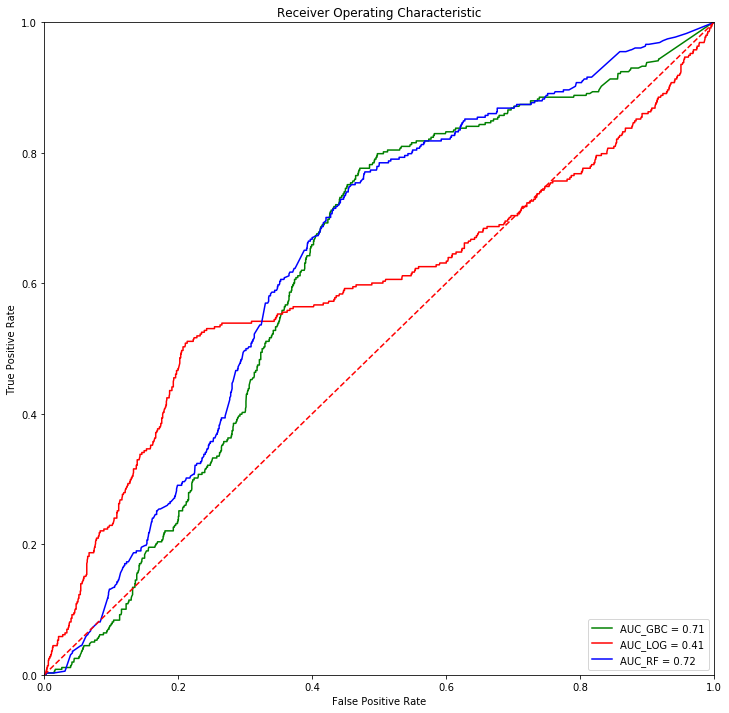

In [56]:
from sklearn import metrics

# calculate the fpr and tpr for all thresholds of the classification
#Gradient Boosting
gbc_probs_simple = gbc_fitted_simple.predict_proba(X_test_simple)[:,1]
gbc_fpr_simple, gbc_tpr_simple, gbc_threshold_simple = metrics.roc_curve(y_test_simple, gbc_probs_simple, sample_weight=weights_test_simple)
gbc_roc_auc_simple = metrics.auc(gbc_fpr_simple, gbc_tpr_simple)

#Logistic Regression
log_probs_simple = log_fitted_simple.predict_proba(X_test_simple)[:,1]
log_fpr_simple, log_tpr_simple, log_threshold_simple = metrics.roc_curve(y_test_simple, log_probs_simple, sample_weight=weights_test_simple)
log_roc_auc_simple = metrics.auc(log_fpr_simple, log_tpr_simple)

#Random Forest
rf_probs_simple = rf_fitted_simple.predict_proba(X_test_simple)[:,1]
rf_fpr_simple, rf_tpr_simple, rf_threshold_simple = metrics.roc_curve(y_test_simple, rf_probs_simple, sample_weight=weights_test_simple)
rf_roc_auc_simple = metrics.auc(rf_fpr_simple, rf_tpr_simple)

# method I: plt
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title('Receiver Operating Characteristic')
ax.plot(gbc_fpr, gbc_tpr, 'b', label = 'AUC_GBC = %0.2f' % gbc_roc_auc_simple, color='green')
ax.plot(log_fpr, log_tpr, 'b', label = 'AUC_LOG = %0.2f' % log_roc_auc_simple, color='red')
ax.plot(rf_fpr, rf_tpr, 'b', label = 'AUC_RF = %0.2f' % rf_roc_auc_simple , color='blue')
ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
fig.savefig('roc_sep8.png')
plt.show()